In [1]:
from TNetModel import TNet, geodesic_loss, trace_loss, point_alignment_loss, gram_schmidt_orthogonalization

In [2]:
import torch
device = 'cuda'
tnet_model = TNet(k=3).cuda()
ckpt = torch.load(
    "/storage/tnet_model_weights_0.25699647267659503_0.0598757229745388_std_0.11098886281251907_2k.pth",
    map_location=device
)
tnet_model.load_state_dict(ckpt)

/tmp/ipykernel_122/2588124475.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(


<All keys matched successfully>

In [3]:
tnet_model.eval()

TNet(
  (mlp1): Sequential(
    (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [4]:
import utils

Warp 1.8.0 initialized:
   CUDA Toolkit 12.8, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX A4000" (16 GiB, sm_86, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.8.0


In [ ]:
import numpy as np
#meshvertices = np.load("/storage/MeshVerticesAligned.npz")['arr_0']
meshvertices = np.load("/storage/MeshSMALVerticesRandom.npz")['arr_0']
import trimesh
mesh = trimesh.load("meshtest_0.off", process=False) #template models, please replace with MeshTestSample/meshtest_4_ori.off

In [ ]:
from tqdm import tqdm
import torch
pointcloud_all = []
for i in tqdm(range(12000)):
  meshvertices[i] = utils.processmesh(meshvertices[i], mesh.faces)[0]
  pointcloud_all.append(utils.sample_mesh(torch.from_numpy(meshvertices[i]), torch.from_numpy(mesh.faces), sample_count=2000))

100%|██████████| 12000/12000 [01:14<00:00, 160.11it/s]


In [12]:
trainidx = np.load('TrainIndexPairs.npy')
testidx = np.load("TestIndexPairs.npy")
trainidx = trainidx[np.where(trainidx < 12000)]

In [34]:
trainidx = np.load('TrainIndexPairs.npy')
testidx = np.load("TestIndexPairs.npy")
trainidx = trainidx[np.where(trainidx < 12000)]

all_geodloss = []
aligned_pointcloud = []
all_valloss = []
failed = []
threshold = 0.66
np.random.seed(20)
for i in tqdm(range(12000)):
    with torch.no_grad():
        pc_rotated, R_gt = utils.rotate_pc_random_withgt(pointcloud_all[i].cpu()numpy())
        meshvertices[i] = meshvertices[i] @ R_gt.numpy().T
        gt_rotations_batch = (R_gt).float().to(device)[None]   # Shape: (B, 3, 3)
        pc_canonical = pointcloud_all[i].float().cuda()
        pc_canonical = pc_canonical[None]
        pc_rotated = pc_rotated.float().cuda()[None]
        # Forward pass: Get the 6D output from T-Net
        raw_6d_output = tnet_model(pc_rotated) # Shape: (B, 6)

        # Convert 6D output to 3x3 rotation matrix using Gram-Schmidt
        predicted_rotations = gram_schmidt_orthogonalization(raw_6d_output) # Shape: (B, 3, 3)
        #point_clouds_batch =point_clouds_batch * std_point_clouds
        # Calculate geodesic loss
        geodloss = geodesic_loss(predicted_rotations, gt_rotations_batch, L2=False,reduction=None)
        #print(geodloss)
        P_aligned = torch.bmm(pc_rotated, predicted_rotations)  # (B, N, 3)
        meshvertices[i] = meshvertices[i] @ predicted_rotations[0].cpu().numpy()
        P_aligned = P_aligned.cpu().numpy()
        aligned_pointcloud.append(P_aligned)
        all_geodloss.append(geodloss.mean().item())
        if(i in testidx):
            all_valloss.append(geodloss.item())
        if(geodloss > threshold):
            failed.append(i)
    

    
    

100%|██████████| 12000/12000 [00:15<00:00, 799.08it/s]


In [35]:
print(np.std(all_geodloss))
print(np.mean(all_geodloss))
print(np.max(all_geodloss))

print(np.std(all_valloss))
print(np.mean(all_valloss))
print(np.max(all_valloss))

print(len(failed))

0.11584061927070614
0.28125973938258053
2.052990674972534
0.12097511017848823
0.28014532327651975
0.6482709050178528
24


In [36]:
np.savez_compressed("/storage/MeshVerticesAligned.npz", meshvertices)
np.savez_compressed("/storage/PointCloudAligned.npz", np.array(aligned_pointcloud))
np.save("/storage/geodloss_all.npy", np.array(all_geodloss))
np.save("/storage/failed_above_0.66.npy", np.array(failed))

In [46]:
np.where(np.array(all_geodloss) > 2)

(array([3530]),)

In [47]:
import trimesh
import numpy as np

# Load or create a mesh (example: built-in sphere)
mesh = trimesh.Trimesh(vertices = meshvertices[3530], faces = mesh.faces)

# Create a random point cloud (e.g., 100 points on the sphere surface)
points = aligned_pointcloud[3530][0]#trimesh.sample.sample_surface(mesh, 100)[0]  # returns (points, face_indices)

# Create a PointCloud object
point_cloud = trimesh.points.PointCloud(points, colors=[255, 0, 0, 255])  # Red color

# Create a scene and add both mesh and point cloud
scene = trimesh.Scene()
scene.add_geometry(mesh)
scene.add_geometry(point_cloud)

# Show the scene (opens in viewer or notebook)
scene.show()


In [10]:
import trimesh
import numpy as np

# Load or create a mesh (example: built-in sphere)
mesh_ori = trimesh.Trimesh(vertices = meshvertices_ori[1000], faces = mesh.faces)
mesh = trimesh.Trimesh(vertices = meshvertices[3530], faces = mesh.faces)
mesh.visual.face_colors = [255, 0, 0, 255]  # Red
# Create a random point cloud (e.g., 100 points on the sphere surface)
#points = aligned_pointcloud[3530][0]#trimesh.sample.sample_surface(mesh, 100)[0]  # returns (points, face_indices)

# Create a PointCloud object
#point_cloud = trimesh.points.PointCloud(points, colors=[255, 0, 0, 255])  # Red color

# Create a scene and add both mesh and point cloud
scene = trimesh.Scene()
scene.add_geometry(mesh)
scene.add_geometry(mesh_ori)

# Show the scene (opens in viewer or notebook)
scene.show()


In [13]:
verts_res = meshvertices
print(np.min(verts_res.reshape(-1,3), axis=0))
print(np.max(verts_res.reshape(-1,3), axis=0))
print(np.std(verts_res[trainidx].reshape(-1,3), axis=0))
print(np.mean(verts_res[trainidx].reshape(-1,3), axis=0))

[-1.1985372  -0.45450002 -0.60324514]
[0.62395287 0.4370688  0.5668454 ]
[0.27175936 0.10233479 0.2042863 ]
[ 1.1345062e-01  7.7768716e-05 -8.0925278e-02]


In [14]:
voxels_centers, voxel_centers_batched = utils.getVoxelCenters(resolution=121)

In [16]:
voxels_all = []
import torch
for i in tqdm(range(12000)):
    voxres = utils.getVoxelResult(verts_res[i], torch.from_numpy(mesh.faces).cuda(), voxel_centers_batched, resolution = 121, pitch=0.02)
    voxels_all.append(np.packbits(voxres.detach().cpu().numpy().flatten()))

  0%|          | 0/12000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/kaolin/ops/conversions/pointcloud.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  vg = torch.sparse.FloatTensor(
100%|██████████| 12000/12000 [36:37<00:00,  5.46it/s]


In [17]:
import numpy as np

resolution = 121

voxel_volume = resolution ** 3
from tqdm import tqdm
# Allocate output array
trainidx = np.load("TrainIndexPairs.npy")
trainidx = trainidx[np.where(trainidx<12000)]
num_voxels = len(trainidx)  # voxels_all: shape (B, 190109)

unpacked_voxels_train = np.empty((num_voxels, resolution, resolution, resolution), dtype=bool)

# Unpack each voxel grid
for i in tqdm(range(num_voxels)):
    idx = trainidx[i]
    packed = voxels_all[idx]  # shape: (190109,)
    flat = np.unpackbits(packed)[:voxel_volume]  # truncate extra bits
    unpacked_voxels_train[i] = flat.reshape((resolution, resolution, resolution))


100%|██████████| 11699/11699 [02:06<00:00, 92.40it/s] 


In [18]:
from tqdm import tqdm
std = []
unpacked_voxels_train = unpacked_voxels_train.reshape(trainidx.shape[0], -1)
for i in tqdm(range(unpacked_voxels_train.shape[1])):
    std.append(np.std(unpacked_voxels_train[:,i]))


100%|██████████| 1771561/1771561 [17:00<00:00, 1736.21it/s]


In [19]:
del unpacked_voxels_train

In [20]:

std = np.array(std)
np.save("/storage/STD_voxels_kaolin_TNetalign.npy", std)
print(np.sum(std < 0.14))
indexinclude = np.where(std > 0.14)
print(indexinclude[0].shape)
print(indexinclude)
print(np.median(std))
np.save("/storage/IndexInclude_0_14stdfil_kaolin_TNetalign.npy", indexinclude[0])
np.save("/storage/VoxelsCenters_all_121resKaolin_TNetalign.npy",np.array(voxels_centers.detach().cpu()) )

#unpacked_voxels_train_filter = unpacked_voxels_train[:, indexinclude[0]]


1745814
(25747,)
(array([ 255980,  256100,  256101, ..., 1267055, 1267056, 1267057]),)
0.0


In [21]:
vox_center_include = voxels_centers[indexinclude[0]][None]

In [24]:
from sklearn.neighbors import NearestNeighbors
def compute_udf(pc: np.ndarray, vox_center_include: np.ndarray) -> np.ndarray:
    """
    Compute UDF (Unsigned Distance Function) from vox_center_include to the point cloud pc.

    Args:
        pc: (N, 3) array of point cloud data
        vox_center_include: (M, 3) array of query points

    Returns:
        udf: (M,) array of unsigned distances to the nearest point in pc
    """
    # Fit nearest neighbors model on point cloud
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
    nn.fit(pc)

    # Query distances from each voxel center to the closest point in the point cloud
    distances, _ = nn.kneighbors(vox_center_include)

    return distances[:, 0]
udf_all = []
for i in tqdm(range(12000)):
    pc = utils.sample_mesh(torch.from_numpy(verts_res[i]), torch.from_numpy(mesh.faces), sample_count=8000)
    udf = compute_udf(pc.numpy(), vox_center_include[0].cpu().numpy())
    udf_all.append(udf)

100%|██████████| 12000/12000 [19:15<00:00, 10.38it/s]


In [25]:
np.array(udf_all).shape

(12000, 25747)

In [26]:
trainidx = np.load("TrainIndexPairs.npy")
trainidx = trainidx[trainidx < 12000] 
udf_train = np.array(udf_all)[trainidx]

In [27]:
from sklearn.decomposition import  IncrementalPCA, PCA

n_components = 400
ipca = PCA(n_components=n_components)

X_ipca = ipca.fit(udf_train)

In [28]:
pca_rep_all = X_ipca.transform(np.array(udf_all))

In [29]:
np.save("/storage/pcaUDFVertProcess_all_TNetalign.npy", pca_rep_all)

In [30]:
np.cumsum(X_ipca.explained_variance_ratio_)[:400]

array([0.23880429, 0.43308127, 0.53008707, 0.60945948, 0.67670858,
       0.72586322, 0.76319805, 0.78645568, 0.8039545 , 0.81945661,
       0.83340234, 0.84573061, 0.85578035, 0.8644269 , 0.8720328 ,
       0.87888068, 0.88501407, 0.89033807, 0.89468021, 0.89875855,
       0.90266819, 0.90607364, 0.90909188, 0.91197948, 0.91450822,
       0.91695414, 0.91935905, 0.92159329, 0.92362735, 0.92555418,
       0.92732839, 0.92904289, 0.93059418, 0.93213937, 0.93363142,
       0.93502546, 0.93636094, 0.93765084, 0.9389137 , 0.94015538,
       0.94134313, 0.94244008, 0.94351234, 0.94452328, 0.94553224,
       0.94649009, 0.94740046, 0.94828087, 0.94911312, 0.94992888,
       0.95071757, 0.95148413, 0.95221485, 0.95292321, 0.95359299,
       0.95423878, 0.95487197, 0.95548725, 0.95609774, 0.95667704,
       0.95723044, 0.95776837, 0.95830204, 0.9588218 , 0.95933829,
       0.95984999, 0.96033722, 0.96082297, 0.9613048 , 0.9617621 ,
       0.96220472, 0.96263763, 0.96306131, 0.96348077, 0.96389

In [31]:
pcarep_train = pca_rep_all[trainidx]
np.save("/storage/PCAUDFMean_std_0_14fil_center_scale_TNetalign.npy", pcarep_train.mean(axis=0))
np.save("/storage/PCAUDFSTD_std_0_14fil_center_scale_TNetalign.npy", pcarep_train.std(axis=0))

In [32]:
import pickle

# Save
with open('/storage/pcaUDF_model_shapematch__0_14fil__TNetalign.pkl', 'wb') as f:
    pickle.dump(X_ipca, f)

2025-07-05 06:10:36.387 (  23.026s) [    7F0CE41F4000]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


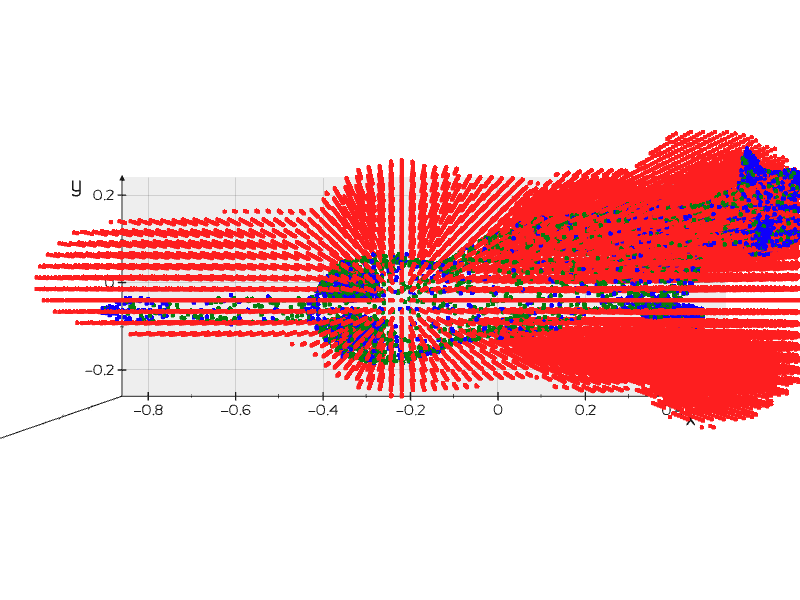

In [35]:
from vedo import Points, show
import numpy as np

# Example point clouds (replace with your actual arrays)
#pc1 = np.random.randn(1000, 3)
#pc2 = np.random.randn(1000, 3) + [2, 2, 2]  # Shifted
pc_all = np.load("/storage/PointCloudAligned.npz")['arr_0']
# Create vedo Point objects
cloud1 = Points(vox_center_include[0].cpu().numpy(), r=5, c='red')
cloud2 = Points(pc_all[1200][0], r=5, c='green')
cloud3 = Points(verts_res[1200], r=5, c='blue')

# Show both point clouds in Jupyter
show(cloud1, cloud2, cloud3, axes=1, interactive=True)



#plot_pc_plotly(vox_center_include[0].cpu().numpy(), pc_all[10])

In [38]:
import trimesh
import numpy as np

# Load or create a mesh (example: built-in sphere)
#mesh_ori = trimesh.Trimesh(vertices = meshvertices_ori[1000], faces = mesh.faces)
#mesh = trimesh.Trimesh(vertices = meshvertices[3530], faces = mesh.faces)
#mesh.visual.face_colors = [255, 0, 0, 255]  # Red
# Create a random point cloud (e.g., 100 points on the sphere surface)
#points = aligned_pointcloud[3530][0]#trimesh.sample.sample_surface(mesh, 100)[0]  # returns (points, face_indices)

# Create a PointCloud object
voxcenter = trimesh.points.PointCloud(vox_center_include[0].cpu().numpy(), colors=[255, 0, 0, 100])  # Red color
pc1 = trimesh.points.PointCloud(pc_all[1200][0], colors=[0, 200, 0, 255])  # Red color
pc2 = trimesh.points.PointCloud(verts_res[1200], colors=[0, 0, 220, 255])  # Red color
# Create a scene and add both mesh and point cloud
scene = trimesh.Scene()
scene.add_geometry(voxcenter)
scene.add_geometry(pc1)
scene.add_geometry(pc2)

# Show the scene (opens in viewer or notebook)
scene.show()
